# 00 - Preprocessing: Wetland Heuristic Labeling

Create a labeled dataset using a heuristic based on wetland indicator species.

**Goal:** Label checklists as 'wetland' or 'non-wetland' based on species composition.

**Steps:**
1. Load eBird data
2. Define wetland indicator species
3. Calculate wetland species proportion for each checklist
4. Apply threshold to label checklists
5. Create balanced dataset
6. Save labeled data

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

from src.data import load_ebird_data

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: wetland_prediction


## 1. Load eBird Data

In [2]:
# Load Kerala eBird data
data_path = project_root / 'data' / 'raw' / 'ebd_IN-KL_smp_relSep-2025.txt'

print(f'Loading eBird data from: {data_path}')
print('This may take a few minutes...\n')

df = load_ebird_data(str(data_path), nrows=1000000)

print(f'\n✓ Loaded {len(df):,} observations')
print(f'  Unique checklists: {df["SAMPLING EVENT IDENTIFIER"].nunique():,}')
print(f'  Unique species: {df["COMMON NAME"].nunique():,}')

Loading eBird data from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\raw\ebd_IN-KL_smp_relSep-2025.txt
This may take a few minutes...

✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 1,000,000
  Columns: 53
  (Limited to first 1,000,000 rows)

✓ Loaded 1,000,000 observations
  Unique checklists: 75,093
  Unique species: 680


## 2. Define Wetland Indicator Species

Wetland-associated birds in Kerala typically include:
- **Ducks & Geese:** Spot-billed Duck, Lesser Whistling-Duck, etc.
- **Herons & Egrets:** Little Egret, Grey Heron, Purple Heron, etc.
- **Waders/Shorebirds:** Black-winged Stilt, Common Sandpiper, etc.
- **Rails & Crakes:** White-breasted Waterhen, Common Moorhen, etc.
- **Kingfishers:** Common Kingfisher, Pied Kingfisher, etc.

In [3]:
# Define wetland indicator species
# You can expand this list based on domain knowledge
WETLAND_SPECIES = [
    # Ducks and Geese
    'Spot-billed Duck', 'Lesser Whistling-Duck', 'Cotton Pygmy-Goose',
    'Garganey', 'Northern Pintail', 'Northern Shoveler', 'Tufted Duck',
    
    # Herons and Egrets
    'Little Egret', 'Great Egret', 'Intermediate Egret', 'Cattle Egret',
    'Grey Heron', 'Purple Heron', 'Indian Pond-Heron', 'Black-crowned Night-Heron',
    'Little Heron', 'Striated Heron',
    
    # Storks and Ibises
    'Painted Stork', 'Asian Openbill', 'Woolly-necked Stork',
    'Black-headed Ibis', 'Glossy Ibis', 'Eurasian Spoonbill',
    
    # Waders and Shorebirds
    'Black-winged Stilt', 'Red-wattled Lapwing', 'Common Sandpiper',
    'Green Sandpiper', 'Wood Sandpiper', 'Common Redshank',
    'Marsh Sandpiper', 'Little Ringed Plover', 'Common Snipe',
    
    # Rails and Crakes
    'White-breasted Waterhen', 'Common Moorhen', 'Purple Swamphen',
    'Baillon\'s Crake', 'Ruddy-breasted Crake',
    
    # Kingfishers
    'Common Kingfisher', 'White-throated Kingfisher', 'Pied Kingfisher',
    'Stork-billed Kingfisher',
    
    # Cormorants
    'Little Cormorant', 'Indian Cormorant', 'Great Cormorant',
    
    # Others
    'Little Grebe', 'Oriental Darter', 'Pheasant-tailed Jacana',
    'Bronze-winged Jacana', 'River Tern', 'Whiskered Tern'
]

print(f'Defined {len(WETLAND_SPECIES)} wetland indicator species')
print(f'\nSample species:')
for sp in WETLAND_SPECIES[:10]:
    print(f'  - {sp}')
print(f'  ... and {len(WETLAND_SPECIES) - 10} more')

Defined 50 wetland indicator species

Sample species:
  - Spot-billed Duck
  - Lesser Whistling-Duck
  - Cotton Pygmy-Goose
  - Garganey
  - Northern Pintail
  - Northern Shoveler
  - Tufted Duck
  - Little Egret
  - Great Egret
  - Intermediate Egret
  ... and 40 more


In [4]:
# Check how many of these species are in our dataset
species_in_data = df['COMMON NAME'].unique()
wetland_in_data = [sp for sp in WETLAND_SPECIES if sp in species_in_data]
wetland_not_in_data = [sp for sp in WETLAND_SPECIES if sp not in species_in_data]

print(f'Wetland species check:')
print(f'  Found in dataset: {len(wetland_in_data)}/{len(WETLAND_SPECIES)}')
print(f'  Not found: {len(wetland_not_in_data)}')

if wetland_not_in_data:
    print(f'\nSpecies not found in dataset:')
    for sp in wetland_not_in_data[:5]:
        print(f'  - {sp}')
    if len(wetland_not_in_data) > 5:
        print(f'  ... and {len(wetland_not_in_data) - 5} more')

Wetland species check:
  Found in dataset: 41/50
  Not found: 9

Species not found in dataset:
  - Spot-billed Duck
  - Intermediate Egret
  - Cattle Egret
  - Grey Heron
  - Black-crowned Night-Heron
  ... and 4 more


## 3. Calculate Wetland Species Proportion per Checklist

In [5]:
# Mark wetland species
df['is_wetland_species'] = df['COMMON NAME'].isin(WETLAND_SPECIES)

# Calculate wetland proportion for each checklist
checklist_stats = df.groupby('SAMPLING EVENT IDENTIFIER').agg({
    'COMMON NAME': 'count',  # Total species count
    'is_wetland_species': 'sum',  # Wetland species count
    'LOCALITY': 'first',
    'LATITUDE': 'first',
    'LONGITUDE': 'first',
    'OBSERVATION DATE': 'first'
}).reset_index()

# Rename columns
checklist_stats.columns = [
    'SAMPLING EVENT IDENTIFIER', 'total_species', 'wetland_species',
    'LOCALITY', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE'
]

# Calculate proportion
checklist_stats['wetland_proportion'] = (
    checklist_stats['wetland_species'] / checklist_stats['total_species']
)

print(f'Checklist statistics:')
print(f'  Total checklists: {len(checklist_stats):,}')
print(f'\nWetland proportion summary:')
print(checklist_stats['wetland_proportion'].describe())

Checklist statistics:
  Total checklists: 75,093

Wetland proportion summary:
count    75093.000000
mean         0.165725
std          0.206685
min          0.000000
25%          0.000000
50%          0.090909
75%          0.272727
max          1.000000
Name: wetland_proportion, dtype: float64


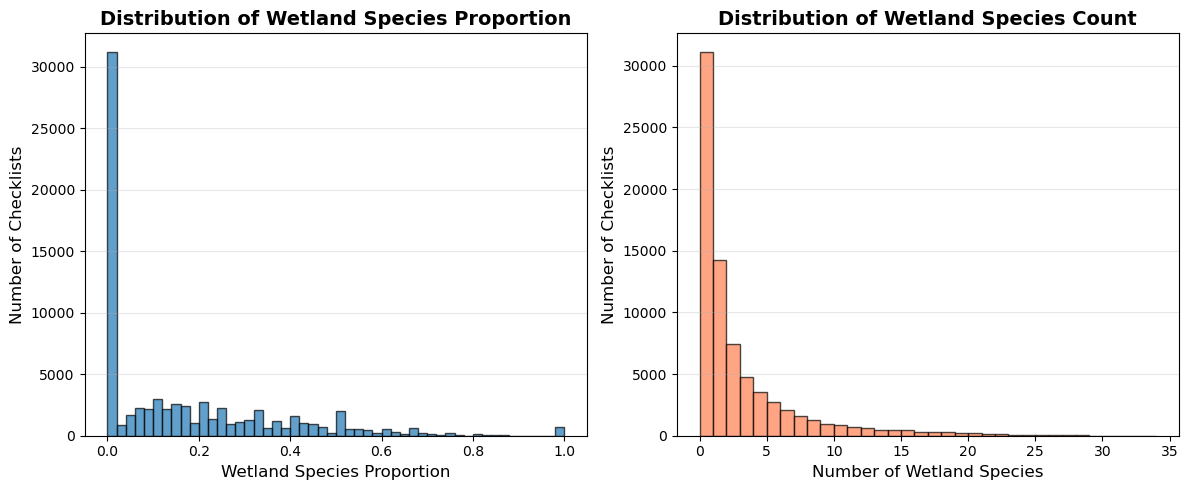

In [6]:
# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(checklist_stats['wetland_proportion'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Wetland Species Proportion', fontsize=12)
plt.ylabel('Number of Checklists', fontsize=12)
plt.title('Distribution of Wetland Species Proportion', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(checklist_stats['wetland_species'], bins=range(0, checklist_stats['wetland_species'].max()+1), 
         edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Number of Wetland Species', fontsize=12)
plt.ylabel('Number of Checklists', fontsize=12)
plt.title('Distribution of Wetland Species Count', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Apply Threshold to Label Checklists

In [7]:
# Define threshold
# Checklist is 'wetland' if >= 30% of species are wetland indicators
WETLAND_THRESHOLD = 0.30

# Apply labeling
checklist_stats['is_wetland'] = (
    checklist_stats['wetland_proportion'] >= WETLAND_THRESHOLD
)

# Convert to string labels
checklist_stats['label'] = checklist_stats['is_wetland'].apply(
    lambda x: 'wetland' if x else 'non-wetland'
)

print(f'Labeling with threshold: {WETLAND_THRESHOLD:.0%}')
print(f'\nLabel distribution:')
print(checklist_stats['label'].value_counts())
print(f'\nPercentages:')
print(checklist_stats['label'].value_counts(normalize=True) * 100)

Labeling with threshold: 30%

Label distribution:
label
non-wetland    57746
wetland        17347
Name: count, dtype: int64

Percentages:
label
non-wetland    76.899312
wetland        23.100688
Name: proportion, dtype: float64


## 5. Create Balanced Dataset (Optional)

In [8]:
# Check if we need balancing
wetland_count = (checklist_stats['label'] == 'wetland').sum()
non_wetland_count = (checklist_stats['label'] == 'non-wetland').sum()

print(f'Original dataset:')
print(f'  Wetland: {wetland_count:,}')
print(f'  Non-wetland: {non_wetland_count:,}')
print(f'  Ratio: 1:{non_wetland_count/wetland_count:.2f}')

# If highly imbalanced, create balanced subset
if non_wetland_count > 2 * wetland_count:
    print(f'\nCreating balanced dataset...')
    
    # Sample equal numbers from each class
    min_count = min(wetland_count, non_wetland_count)
    
    wetland_df = checklist_stats[checklist_stats['label'] == 'wetland'].sample(
        n=min_count, random_state=42
    )
    non_wetland_df = checklist_stats[checklist_stats['label'] == 'non-wetland'].sample(
        n=min_count, random_state=42
    )
    
    balanced_df = pd.concat([wetland_df, non_wetland_df], ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    
    print(f'\nBalanced dataset:')
    print(f'  Total: {len(balanced_df):,}')
    print(f'  Wetland: {(balanced_df["label"] == "wetland").sum():,}')
    print(f'  Non-wetland: {(balanced_df["label"] == "non-wetland").sum():,}')
    
    final_df = balanced_df
else:
    print(f'\nDataset is reasonably balanced, using all data.')
    final_df = checklist_stats

print(f'\n✓ Final dataset size: {len(final_df):,}')

Original dataset:
  Wetland: 17,347
  Non-wetland: 57,746
  Ratio: 1:3.33

Creating balanced dataset...

Balanced dataset:
  Total: 34,694
  Wetland: 17,347
  Non-wetland: 17,347

✓ Final dataset size: 34,694


## 6. Save Labeled Dataset

In [9]:
# Save to processed folder
output_path = Path('../data/processed')
output_path.mkdir(parents=True, exist_ok=True)

save_path = output_path / 'wetland_proportion_labeled.npz'

# Save as npz
np.savez_compressed(
    save_path,
    sampling_event_ids=final_df['SAMPLING EVENT IDENTIFIER'].values,
    labels=final_df['label'].values,
    wetland_proportion=final_df['wetland_proportion'].values,
    wetland_species_count=final_df['wetland_species'].values,
    total_species_count=final_df['total_species'].values,
    latitude=final_df['LATITUDE'].values,
    longitude=final_df['LONGITUDE'].values,
    locality=final_df['LOCALITY'].values,
    # Metadata
    threshold=WETLAND_THRESHOLD,
    n_wetland_species=len(WETLAND_SPECIES)
)

print(f'✓ Saved labeled dataset to: {save_path}')
print(f'  File size: {save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved labeled dataset to: ..\data\processed\wetland_proportion_labeled.npz
  File size: 0.70 MB
  File size: 0.70 MB


In [10]:
# Also save as CSV for easy inspection
csv_path = output_path / 'wetland_proportion_labeled.csv'
final_df.to_csv(csv_path, index=False)

print(f'✓ Saved CSV version to: {csv_path}')

✓ Saved CSV version to: ..\data\processed\wetland_proportion_labeled.csv


## Summary

In [11]:
print('='*70)
print('PREPROCESSING COMPLETE')
print('='*70)
print(f'\n📋 Heuristic:')
print(f'   Wetland indicator species: {len(WETLAND_SPECIES)}')
print(f'   Threshold: {WETLAND_THRESHOLD:.0%} of species must be wetland indicators')
print(f'\n📊 Labeled Dataset:')
print(f'   Total checklists: {len(final_df):,}')
print(f'   Wetland: {(final_df["label"] == "wetland").sum():,}')
print(f'   Non-wetland: {(final_df["label"] == "non-wetland").sum():,}')
print(f'\n💾 Outputs:')
print(f'   NPZ: {save_path.name}')
print(f'   CSV: {csv_path.name}')
print(f'\n✨ Ready for Phase 1: Exploration!')
print('   Next: Run 01_exploration.ipynb')
print('='*70)

PREPROCESSING COMPLETE

📋 Heuristic:
   Wetland indicator species: 50
   Threshold: 30% of species must be wetland indicators

📊 Labeled Dataset:
   Total checklists: 34,694
   Wetland: 17,347
   Non-wetland: 17,347

💾 Outputs:
   NPZ: wetland_proportion_labeled.npz
   CSV: wetland_proportion_labeled.csv

✨ Ready for Phase 1: Exploration!
   Next: Run 01_exploration.ipynb
